# Modelo de Prospectividad Mineral con Machine Learning, Teledetección y magnetometría
Proyecto de Exploración Digital - Franja IOCG, Región de Atacama;
Autor: Pablo Toledo; Fecha: 09/12/2025

**1. Resumen**

Este notebook documenta el flujo de trabajo técnico para la generación de un Mapa de Prospectividad de depósitos tipo IOCG en la Cordillera de la Costa. El objetivo es reducir la incertidumbre exploratoria mediante la integración de múltiples fuentes de datos. Se utiliza un enfoque híbrido que combina Ingeniería de Características (Lógica Difusa y Procesamiento de Imágenes) con Machine Learning Supervisado (Random Forest) para predecir la favorabilidad mineral.

**2. Procesamiento de Datos (Inputs)**

Se procesaron y estandarizaron tres fuentes de información primaria:

* Geofísica (Aeromagnetismo):

Dato Crudo: Grillas magnéticas originales en formato Esri (Bandas RGB separadas).

* Procesamiento: Se realizó la reconstrucción y fusión de bandas mediante Python (rasterio) para generar un único raster GeoTIFF de Intensidad Magnética unificado y georreferenciado.

Teledetección (ASTER L1T):

Procesamiento: Cálculo de índices de alteración (Arcillas/Micas) y aplicación de un algoritmo Isolation Forest para generar un mapa "Score de Anomalía Espectral" (detectando píxeles atípicos).

Geología Vectorial (Sernageomin):

Procesamiento: Cálculo de distancias euclidianas a fallas, diques y contactos, transformadas mediante funciones de Lógica Difusa(Fuzzy Logic) para representar la influencia espacial decreciente.

**3. Metodología del Flujo de Trabajo**

Fusión de Datos (Data Fusion):


Se realizó la alineación espacial para asegurar que cada punto de la base de datos contenga la información de todas las capas para las capas raster; Magnetometría + ASTER

Se consolidaron todas las variables raster y vectoriales (Fuzzy Geológico) en un único Dataset.

Definición del Target:

Etiquetado binario: "Mineral" (menor a 500m de yacimiento conocido) vs "Estéril".

Balanceo de datos: Para evitar que el modelo se sesgara hacia la predicción de "terreno estéril", se aplicó un sub-muestreo controlado de las zonas sin mineralización: 1:3 (undersampling)

Entrenamiento:

Modelo: Random Forest Classifier.

Validación: Validación cruzada espacial (Spatial Cross-Validation) para evitar sesgos por autocorrelación.

**4. Resultados Técnicos**
Producto Final: Mapa de Probabilidad (GeoTIFF) exportable a GIS.

Dimensiones: 49 km x 46 km (Sistema UTM 19S).
   Coordenadas Este (X):       304,240 E - 353,730 E
   Coordenadas Norte (Y):      6,790,366 N - 6,836,188 N

Métricas: Reporte de importancia de variables (Feature Importance) y AUC (0.67) calculado sobre bloques espaciales desconocidos para el modelo.

**5. Referencias**

* Tienda Sernageomin; Geología del área Vallenar-Domeyko. Región de Atacama. 2009. Escala 1:100.000. https://tiendadigital.sernageomin.cl/es/geologia-basica/996-2009-geologia-del-area-vallenar-domeyko-region-de-atacama-escala-1-100000.html y mangetrometria

* Tienda Sernageomin; Magnetometría del área Vallenar-Domeyko, Región de Atacama. 2013. Escala 1:100.000. https://tiendadigital.sernageomin.cl/es/geofisica/1201-2013-magnetometria-del-area-vallenar-domeyko-region-de-atacama-escala-1-100000.html

* hdf : Desde la pagina https://search.earthdata.nasa.gov/; AST_L1T_00308302006145545_20150515232237_38182.hdf

* Se utilizaron asistentes de IA para acelerar la escritura de código Python, permitiendo enfocar el esfuerzo en el análisis de datos, la interpretación geológica y la validación.

**Nota: Este proyecto es un ejercicio diseñado para demostrar un flujo de trabajo, por lo que:**

Los parámetros geológicos utilizados (radios de influencia fuzzy, pesos de variables) son estimaciones teóricas aplicadas con fines demostrativos. Un modelo de exploración requeriría una calibración más rigurosa de estos parámetros basada por ejemplo en: Conocimiento experto del distrito específico, validación de campo detallada y datos geoquímicos complementarios o cualquier otro estudio. ---> Por lo que si bien esta hecho con datos reales, le falta maduración.

In [15]:
# 1: Librerias
import time
import os
import gc
import warnings
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from osgeo import gdal
from scipy.ndimage import median_filter
from scipy.spatial import cKDTree
from scipy.interpolate import griddata
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
import rasterio
from rasterio import features
from rasterio.transform import from_origin
from rasterio.mask import mask
from rasterio.plot import show
from affine import Affine
import seaborn as sns
from sklearn.cluster import KMeans
# Ignorar advertencias molestas
warnings.filterwarnings("ignore")
print("Bibliotecas importadas correctamente.")

Bibliotecas importadas correctamente.


In [2]:
# 2: CARGA Y RECORTE
print(" Carga optimizada y recorte...")

# 1. OBTENER LÍMITES GEOLÓGICOS(Para saber qué cargar)
path_shapes = "/content/drive/MyDrive/Proyectoprospectivo/Data/GEOL/shapes_reproyectados/"
path_lito = os.path.join(path_shapes, "GB_LITO_P_32719.shp")

# Leemos solo el bounding box
gdf_bounds = gpd.read_file(path_lito)
minx, miny, maxx, maxy = gdf_bounds.total_bounds
del gdf_bounds # Borramos esto ya
print(f" Límites definidos por Geología: {minx:.0f} - {maxx:.0f} E, {miny:.0f} - {maxy:.0f} N")

# 2. CARGAR DATASET MAESTRO
input_folder = '/content/drive/MyDrive/Proyectoprospectivo/Data/TABLAS/'
file_name = 'Dataset_Maestro_Con_Mag_Final.parquet'
file_path = os.path.join(input_folder, file_name)

if os.path.exists(file_path):
    print("   Cargando tabla en memoria...")
    # Archivo completo
    df_temp = pd.read_parquet(file_path)

    registros_totales = len(df_temp)
    print(f"      Total en disco: {registros_totales:,} filas.")

    # 3. APLICAR CLIP(Sobrescribir para liberar RAM)
    print(" Recortando excesos inmediatamente...")

    # Filtramos
    df_dataset = df_temp[
        (df_temp['Este_UTM'] >= minx) &
        (df_temp['Este_UTM'] <= maxx) &
        (df_temp['Norte_UTM'] >= miny) &
        (df_temp['Norte_UTM'] <= maxy)
    ].copy() # .copy() para desvincular la memoria vieja

    # 4. LIMPIEZA DE MEMORIA
    del df_temp # Borramos la tabla gigante original
    gc.collect() # Forzamos al sistema a barrer basura

    reduccion = 100 * (1 - len(df_dataset)/registros_totales)
    print(f"  ¡RAM LIBERADA! Nos quedamos con: {len(df_dataset):,} filas.")
    print(f"  Se descartó el {reduccion:.1f}% de datos inútiles.")
    print(f"  Columnas listas: {list(df_dataset.columns)}")

else:
    print(f" ERROR: No encuentro {file_path}")

 Carga optimizada y recorte...
 Límites definidos por Geología: 304085 - 353730 E, 6789947 - 6846074 N
   Cargando tabla en memoria...
      Total en disco: 6,832,678 filas.
 Recortando excesos inmediatamente...
  ¡RAM LIBERADA! Nos quedamos con: 2,597,855 filas.
  Se descartó el 62.0% de datos inútiles.
  Columnas listas: ['Este_UTM', 'Norte_UTM', 'ASTER_Alteration', 'Anomaly_Score', 'Magnetometria']


In [3]:
# 3: CÁLCULO ESTRUCTURAL (logica difusa, mas modificable e interpretable con geologia)
print("CÁLCULO DE VARIABLES FUZZY (Influencia 0-1)...")

# Ruta shapes
path_shapes = "/content/drive/MyDrive/Proyectoprospectivo/Data/GEOL/shapes_reproyectados/"

# 1. Definir Función Fuzzy (Modificada para aceptar Filtros; que falto a lito)
def calcular_fuzzy(df_puntos, nombre_shape, rango_maximo, filtro_col=None, filtro_texto=None):
    try:
        # Carga shape
        ruta_shp = os.path.join(path_shapes, nombre_shape)
        if not os.path.exists(ruta_shp):
            print(f"    Archivo no encontrado: {nombre_shape}")
            return np.zeros(len(df_puntos), dtype=np.float32)

        gdf = gpd.read_file(ruta_shp)

        # FILTRADO
        if filtro_col and filtro_texto:
            if filtro_col in gdf.columns:
                len_antes = len(gdf)
                # Filtramos buscando el texto (insensible a mayúsculas)
                gdf = gdf[gdf[filtro_col].astype(str).str.contains(filtro_texto, case=False, na=False)]
                print(f"    Filtro aplicado a {nombre_shape}: {len_antes} -> {len(gdf)} elementos ('{filtro_texto}')")
            else:
                print(f"    La columna '{filtro_col}' no existe en {nombre_shape}. Se usará todo el archivo.")
        # --------------------------------------------------------

        if len(gdf) == 0:
             print(f"    El filtro dejó vacío a {nombre_shape}. Retornando ceros.")
             return np.zeros(len(df_puntos), dtype=np.float32)

        print(f"    Procesando {nombre_shape} (Rango: {rango_maximo}m)...")

        # Extraer Coordenadas
        coords = []
        for geom in gdf.geometry:
            if geom.is_empty: continue
            if geom.geom_type in ['LineString', 'MultiLineString']:
                if geom.geom_type == 'LineString': coords.extend(geom.coords)
                else:
                    for g in geom.geoms: coords.extend(g.coords)
            elif geom.geom_type in ['Polygon', 'MultiPolygon']:
                if geom.geom_type == 'Polygon': coords.extend(geom.exterior.coords)
                else:
                    for g in geom.geoms: coords.extend(g.exterior.coords)

        del gdf # Liberar RAM
        gc.collect()

        if not coords: return np.zeros(len(df_puntos), dtype=np.float32)

        # Calcular Distancia
        tree = cKDTree(np.array(coords))
        puntos = df_puntos[['Este_UTM', 'Norte_UTM']].values

        # Se puede variar workers por si hay problemas de ram
        distancias, _ = tree.query(puntos, k=1, workers=1)

        # Aplicar FUZZY (1.0 = Cerca, 0.0 = Lejos)
        influencia = 1.0 - (distancias / rango_maximo)
        influencia = np.clip(influencia, 0.0, 1.0).astype(np.float32)

        del distancias, tree, coords
        gc.collect()
        return influencia

    except Exception as e:
        print(f"   Error procesando {nombre_shape}: {e}")
        return np.zeros(len(df_puntos), dtype=np.float32)

# 2. Ejecutar Cálculos

# Fallas
df_dataset['Fuzzy_Fallas'] = calcular_fuzzy(df_dataset, "GB_FALLA_L_32719.shp", 3000)

# Diques
df_dataset['Fuzzy_Diques'] = calcular_fuzzy(df_dataset, "GB_INT_ASS_EST_L_32719.shp", 1000)

# Pliegues
df_dataset['Fuzzy_Pliegues'] = calcular_fuzzy(df_dataset, "GB_PLIEGUE_L_32719.shp", 2500)

# Contactos (CON FILTRO PARA INTRUSIVOS; Habia olvidado filtrar contactos intrusivos)
df_dataset['Fuzzy_Contactos'] = calcular_fuzzy(
    df_dataset,
    "CONTACTOS_32719.shp",
    1000,
    filtro_col='SUBTIPO_DE',
    filtro_texto='Contacto Intrusivo'
)

print("VARIABLES GEOLÓGICAS CALCULADAS.")

CÁLCULO DE VARIABLES FUZZY (Influencia 0-1)...
    Procesando GB_FALLA_L_32719.shp (Rango: 3000m)...
    Procesando GB_INT_ASS_EST_L_32719.shp (Rango: 1000m)...
    Procesando GB_PLIEGUE_L_32719.shp (Rango: 2500m)...
    Filtro aplicado a CONTACTOS_32719.shp: 2452 -> 617 elementos ('Contacto Intrusivo')
    Procesando CONTACTOS_32719.shp (Rango: 1000m)...
VARIABLES GEOLÓGICAS CALCULADAS.


In [4]:
#  3.5: LITOLOGÍA (Para litologia no usamos fuzzy, sino unidades/litologias que son o no del jurasico/cretacico; binario, si o no)
print(" INTEGRANDO LITOLOGÍA (Ultra Ligero para ahorrar RAM)...")

# 1. Convertimos todo a float32 para reducir el peso a la MITAD antes de seguir
print("    Aplicando compresión de tipos de datos...")
cols_float = df_dataset.select_dtypes(include=['float64']).columns
df_dataset[cols_float] = df_dataset[cols_float].astype('float32')
gc.collect()

# 2. Cargar shapefile
path_shapes = "/content/drive/MyDrive/Proyectoprospectivo/Data/GEOL/shapes_reproyectados/"
gdf_lito = gpd.read_file(os.path.join(path_shapes, "GB_LITO_P_32719.shp"))

# Filtro J/K
col_lito = 'CODIGO' if 'CODIGO' in gdf_lito.columns else 'Nm_Unit'
mask_fav = gdf_lito[col_lito].str.contains('J|K', case=False, regex=True, na=False)
gdf_lito['SCORE'] = mask_fav.astype('uint8')
print(f"   Unidades Favorables: {gdf_lito['SCORE'].sum()}")

# 3. Rasterizar SOLO el Mapa
# Usamos los límites que ya calculamos al recortar (minx, maxx, etc.)
min_x = df_dataset['Este_UTM'].min()
max_x = df_dataset['Este_UTM'].max()
min_y = df_dataset['Norte_UTM'].min()
max_y = df_dataset['Norte_UTM'].max()

# Asumimos tamaño de píxel aprox 30m (promedio para evitar errores)
pixel_size_x = (max_x - min_x) / (np.sqrt(len(df_dataset)) * 1.5) # Estimación o fijo 30
# Truco: Tomamos la diferencia mínima no cero entre coordenadas
uniques_x = np.sort(df_dataset['Este_UTM'].unique()[:1000])
px_w = np.min(np.diff(uniques_x))
# Si da algo raro (<10), forzamos 30 por que el satelite entrega de 30.
if px_w < 10 or np.isnan(px_w): px_w = 30.0

width = int((max_x - min_x) / px_w) + 1
height = int((max_y - min_y) / px_w) + 1

print(f"   Generando grilla temporal de {width}x{height}...")

transform = Affine.translation(min_x, max_y) * Affine.scale(px_w, -px_w)

# Rasterizamos el shapefile a una matriz 2D pequeña (ahorro de RAM)
lito_grid = features.rasterize(
    ((g, v) for g, v in zip(gdf_lito.geometry, gdf_lito['SCORE'])),
    out_shape=(height, width),
    transform=transform,
    fill=0,
    dtype='uint8'
)

# 4. MUESTREO DIRECTO
# En lugar de ordenar la tabla, calculamos el índice (i, j) para cada punto
print("   Cruzando datos espacialmente...")

# Fórmulas inversas: Columna = (X - OrigenX) / AnchoPixel
idx_col = ((df_dataset['Este_UTM'].values - min_x) / px_w).astype(int)
# Fila = (OrigenY - Y) / AltoPixel (porque Y va hacia abajo en imágenes)
idx_row = ((max_y - df_dataset['Norte_UTM'].values) / px_w).astype(int)

# Corregir índices(por si hay pequeños decimales que se salgan de los limites)
idx_col = np.clip(idx_col, 0, width - 1)
idx_row = np.clip(idx_row, 0, height - 1)

# Asignamos valor leyendo directo de la matriz
df_dataset['Lito_Favorable'] = lito_grid[idx_row, idx_col]

# Limpieza total
del gdf_lito, lito_grid, idx_col, idx_row
gc.collect()

print(" LITOLOGÍA INTEGRADA (Sin saturar RAM).")
print(df_dataset['Lito_Favorable'].value_counts())

 INTEGRANDO LITOLOGÍA (Ultra Ligero para ahorrar RAM)...
    Aplicando compresión de tipos de datos...
   Unidades Favorables: 402
   Generando grilla temporal de 1741x1701...
   Cruzando datos espacialmente...
 LITOLOGÍA INTEGRADA (Sin saturar RAM).
Lito_Favorable
1    1795087
0     802768
Name: count, dtype: int64


ENTRENANDO MODELO DE PROSPECTIVIDAD (RANDOM FOREST)...
   Calculando distancia a yacimientos conocidos...
   Píxeles de Entrenamiento (Mineral): 71,456
 Generando Bloques Espaciales...
   Set de Entrenamiento Balanceado: 246,328 muestras.
   Separando Train/Test por BLOQUES COMPLETOS...
   Entrenando Random Forest...
 Iniciando RF...
 Finalizado en 109.98 segundos
EVALUACIÓN DEL RENDIMIENTO:
  AUC-ROC Score: 0.6654


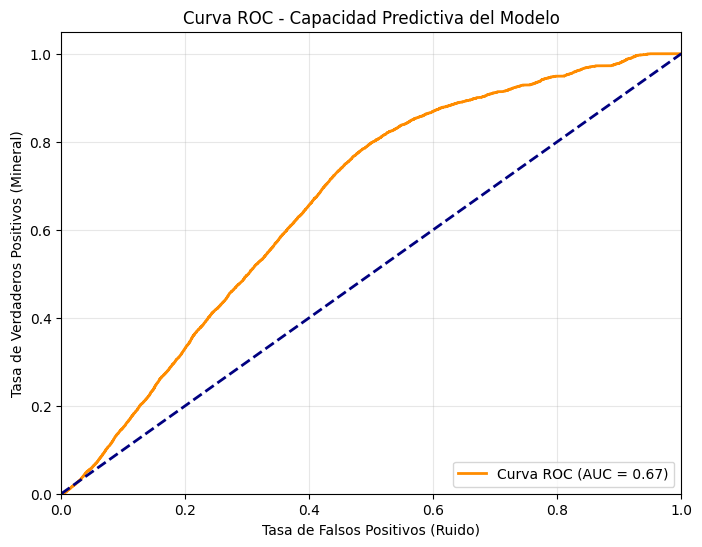

 EVALUACIÓN DEL MODELO:
              precision    recall  f1-score   support

           0       0.71      0.96      0.81     33724
           1       0.34      0.05      0.09     14082

    accuracy                           0.69     47806
   macro avg       0.52      0.50      0.45     47806
weighted avg       0.60      0.69      0.60     47806

   Generando Mapa de Prospectividad Final...


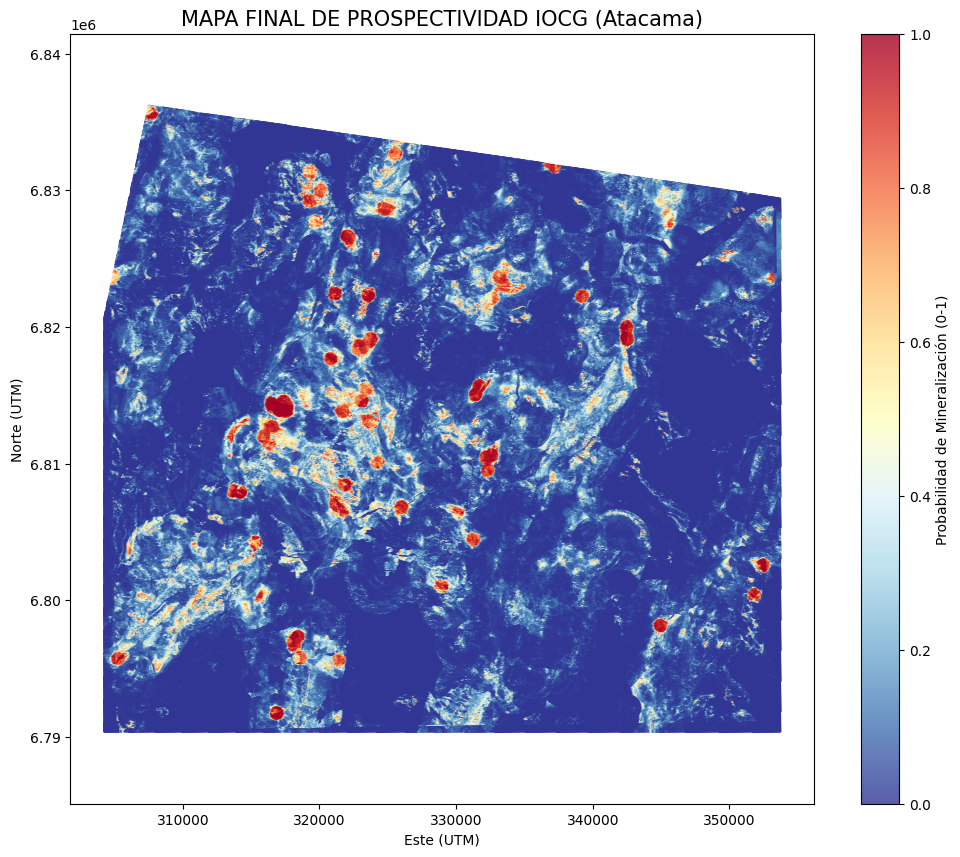

RANKING DE VARIABLES (¿Qué controla la mineralización?):
Fuzzy_Fallas        0.244709
Magnetometria       0.173167
Fuzzy_Pliegues      0.137448
ASTER_Alteration    0.135590
Fuzzy_Contactos     0.112427
Anomaly_Score       0.101757
Fuzzy_Diques        0.055110
Lito_Favorable      0.039792
dtype: float64
 Mapa guardado en: /content/drive/MyDrive/Proyectoprospectivo/Data/TABLAS/Resultado_Final_Prospectividad.csv


In [5]:
# 5: ENTRENAMIENTO Y MAPA FINAL
print("ENTRENANDO MODELO DE PROSPECTIVIDAD (RANDOM FOREST)...")

# 1. DEFINIR EL TARGET (ETIQUETADO)
# Cargamos los Yacimientos conocidos para enseñarle al modelo
path_yac = os.path.join(path_shapes, "YACIMIENTOS_32719.shp")

# Función rápida para calcular distancia a la mina más cercana
def get_dist_yacimientos(df):
    gdf_yac = gpd.read_file(path_yac)
    coords_minas = np.vstack([np.array(g.coords) for g in gdf_yac.geometry])
    tree = cKDTree(coords_minas)
    dists, _ = tree.query(df[['Este_UTM', 'Norte_UTM']].values, k=1, workers=1)
    return dists

print("   Calculando distancia a yacimientos conocidos...")
dist_a_minas = get_dist_yacimientos(df_dataset)

# Regla que le damos: Si está a menos de 500m de una mina conocida, es "Clase 1" (Mineral)
# El resto es "Clase 0" (Estéril / Desconocido)
df_dataset['Target'] = (dist_a_minas < 500).astype('uint8')
print(f"   Píxeles de Entrenamiento (Mineral): {df_dataset['Target'].sum():,}")

# 2. LIMPIEZA Y PREPARACIÓN
# Eliminamos filas que tengan algún NaN (bordes de imagen, etc)
df_clean = df_dataset.dropna().copy()

print(" Generando Bloques Espaciales...")
coords = df_clean[['Este_UTM', 'Norte_UTM']].values
# Creamos 20 "Distritos Virtuales" (Clusters) para separar geográficamente
kmeans = KMeans(n_clusters=20, random_state=42, n_init=10)
df_clean['Spatial_Block'] = kmeans.fit_predict(coords)

# 3. BALANCEO DE CLASES
# Hay millones de píxeles estériles y pocos minerales
# Si no balanceamos, el modelo dirá "nada es mineral" y acertará el 99%, pero no sirve
df_mineral = df_clean[df_clean['Target'] == 1]
# Tomamos una muestra de estériles (3 veces la cantidad de mineral)
df_esteril = df_clean[df_clean['Target'] == 0].sample(n=len(df_mineral)*3, random_state=42)

df_train = pd.concat([df_mineral, df_esteril])
print(f"   Set de Entrenamiento Balanceado: {len(df_train):,} muestras.")

# 4. DEFINIR VARIABLES PREDICTORAS (FEATURES)
features = [
    'ASTER_Alteration',   # Espectral
    'Anomaly_Score',      # Indice de anomalias
    'Fuzzy_Fallas',       # Estructural Regional
    'Fuzzy_Diques',       # Estructural Local
    'Fuzzy_Pliegues',     # Trampas
    'Fuzzy_Contactos',    # Litológico
    'Lito_Favorable',      # Roca Caja
    'Magnetometria'
]

# 5. SPLIT ESPACIAL
print("   Separando Train/Test por BLOQUES COMPLETOS...")
splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
groups = df_train['Spatial_Block']

# Obtenemos índices de bloques separados
train_idx, test_idx = next(splitter.split(df_train, groups=groups))

X_train = df_train.iloc[train_idx][features]
y_train = df_train.iloc[train_idx]['Target']
X_test = df_train.iloc[test_idx][features]
y_test = df_train.iloc[test_idx]['Target']

# 5. ENTRENAMIENTO
print("   Entrenando Random Forest...")

# Configuración
rf = RandomForestClassifier(
    n_estimators=300,   # 300 árboles de decisión
    max_depth=20,       # Profundidad limitada para no memorizar (overfitting)
    n_jobs=-1,          # Usar todos los núcleos
    random_state=42
)
print(" Iniciando RF...")
inicio = time.time() # <--- INICIO CRONÓMETRO

rf.fit(X_train, y_train)

fin = time.time() # <--- FIN CRONÓMETRO
tiempo_total = fin - inicio

print(f" Finalizado en {tiempo_total:.2f} segundos")

# 6. EVALUACIÓN AUC-ROC

print("EVALUACIÓN DEL RENDIMIENTO:")

# Calculamos probabilidad en el set de prueba (necesario para curva ROC)
y_probs_test = rf.predict_proba(X_test)[:, 1]

# Calcular Score AUC (0.5 = Azar, 1.0 = Perfecto)
roc_auc = roc_auc_score(y_test, y_probs_test)
print(f"  AUC-ROC Score: {roc_auc:.4f}")


# Generar Gráfico de Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_probs_test)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Línea de azar
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (Ruido)')
plt.ylabel('Tasa de Verdaderos Positivos (Mineral)')
plt.title('Curva ROC - Capacidad Predictiva del Modelo')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

# Reporte de Calidad
print(" EVALUACIÓN DEL MODELO:")
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

# 7. GENERAR EL MAPA (PREDICCIÓN ESPACIAL)
print("   Generando Mapa de Prospectividad Final...")
# Predecimos sobre TODO el área limpia, no solo el set de entrenamiento
probs_finales = rf.predict_proba(df_clean[features])[:, 1] # Probabilidad de Clase 1

# Guardamos la probabilidad en la tabla
df_clean['Probabilidad_IOCG'] = probs_finales

# 8. VISUALIZACIÓN
plt.figure(figsize=(12, 10))
# Plot de todos los puntos (usamos s=0.1 para que parezca imagen)
sc = plt.scatter(df_clean['Este_UTM'], df_clean['Norte_UTM'],
                 c=df_clean['Probabilidad_IOCG'],
                 cmap='RdYlBu_r', # Rojo = Alto, Azul = Bajo
                 s=0.2, alpha=0.8)
plt.colorbar(sc, label='Probabilidad de Mineralización (0-1)')
plt.title("MAPA FINAL DE PROSPECTIVIDAD IOCG (Atacama)", fontsize=15)
plt.xlabel("Este (UTM)")
plt.ylabel("Norte (UTM)")
plt.axis('equal')
plt.show()

# 8. IMPORTANCIA DE VARIABLES
imp = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
print("RANKING DE VARIABLES (¿Qué controla la mineralización?):")
print(imp)

# 9. GUARDAR RESULTADO FINAL
save_path = '/content/drive/MyDrive/Proyectoprospectivo/Data/TABLAS/Resultado_Final_Prospectividad.csv'
# Guardamos solo coordenadas y probabilidad para que sea liviano
df_clean[['Este_UTM', 'Norte_UTM', 'Probabilidad_IOCG']].to_csv(save_path, index=False)
print(f" Mapa guardado en: {save_path}")

REPORTE...
RESUMEN EJECUTIVO:
   ---------------------------------------
   Dimensiones del Mapa:       49.5 km (Ancho) x 45.8 km (Alto)
   Coordenadas Este (X):       304,240 E - 353,730 E
   Coordenadas Norte (Y):      6,790,366 N - 6,836,188 N
   ---------------------------------------
   Área Total Cubierta:        2267.7 km² (Bounding Box)
   Área Geológica Efectiva:    2039.2 km² (Datos reales procesados)
   ---------------------------------------


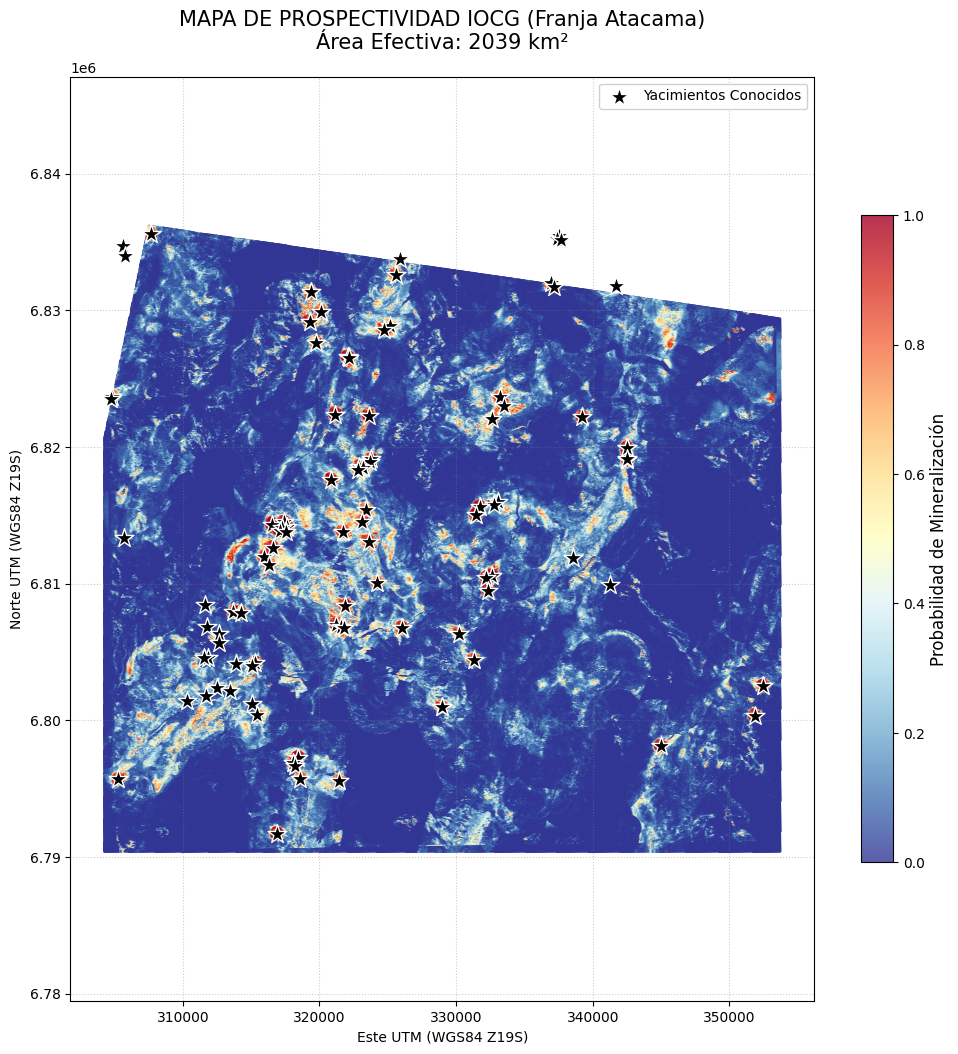

In [6]:
# 6: REPORTE DIMENSIONES Y MAPA DE TARGETS PARA VISUALIZAR
print("REPORTE...")

# 1. Cargar Yacimientos para graficar encima
path_yac = "/content/drive/MyDrive/Proyectoprospectivo/Data/GEOL/shapes_reproyectados/YACIMIENTOS_32719.shp"
gdf_yac = gpd.read_file(path_yac)

# 2. Calcular Estadísticas Geográficas
min_x = df_clean['Este_UTM'].min()
max_x = df_clean['Este_UTM'].max()
min_y = df_clean['Norte_UTM'].min()
max_y = df_clean['Norte_UTM'].max()

# Dimensiones en Kilómetros
ancho_km = (max_x - min_x) / 1000
alto_km = (max_y - min_y) / 1000

# Área Efectiva (Suma de píxeles procesados)
# Un píxel ASTER mide aprox 30x30m = 900 m2
num_pixeles = len(df_clean)
area_efectiva_km2 = (num_pixeles * 900) / 1_000_000

print(f"RESUMEN EJECUTIVO:")
print(f"   ---------------------------------------")
print(f"   Dimensiones del Mapa:       {ancho_km:.1f} km (Ancho) x {alto_km:.1f} km (Alto)")
print(f"   Coordenadas Este (X):       {min_x:,.0f} E - {max_x:,.0f} E")
print(f"   Coordenadas Norte (Y):      {min_y:,.0f} N - {max_y:,.0f} N")
print(f"   ---------------------------------------")
print(f"   Área Total Cubierta:        {ancho_km * alto_km:.1f} km² (Bounding Box)")
print(f"   Área Geológica Efectiva:    {area_efectiva_km2:.1f} km² (Datos reales procesados)")
print(f"   ---------------------------------------")

# 3. VISUALIZACIÓN
plt.figure(figsize=(12, 12))

# A. Mapa de Probabilidad (El resultado del RF)
# Usamos alpha=0.9 para que los colores sean vibrantes
sc = plt.scatter(df_clean['Este_UTM'], df_clean['Norte_UTM'],
                 c=df_clean['Probabilidad_IOCG'],
                 cmap='RdYlBu_r',
                 s=0.2, alpha=0.8)

# Barra de color
cbar = plt.colorbar(sc, shrink=0.7)
cbar.set_label('Probabilidad de Mineralización', fontsize=12)

# B. Superponer Yacimientos (Validación)
# Filtramos solo los que caen dentro del mapa para limpieza visual
gdf_yac_clip = gdf_yac.cx[min_x:max_x, min_y:max_y]

plt.scatter(gdf_yac_clip.geometry.x, gdf_yac_clip.geometry.y,
            c='black', marker='*', s=200, edgecolors='white', linewidth=1,
            label='Yacimientos Conocidos', zorder=10)

plt.title(f"MAPA DE PROSPECTIVIDAD IOCG (Franja Atacama)\nÁrea Efectiva: {area_efectiva_km2:.0f} km²", fontsize=15, pad=20)
plt.xlabel("Este UTM (WGS84 Z19S)", fontsize=10)
plt.ylabel("Norte UTM (WGS84 Z19S)", fontsize=10)
plt.legend(loc='upper right', frameon=True, facecolor='white', framealpha=0.9)
plt.grid(True, linestyle=':', alpha=0.4, color='gray')
plt.axis('equal')

plt.show()

INICIANDO PROCESO FINAL (CORREGIDO)...
Interpolando datos (Linear)...
Recortando con Geología...
Generando PNG...


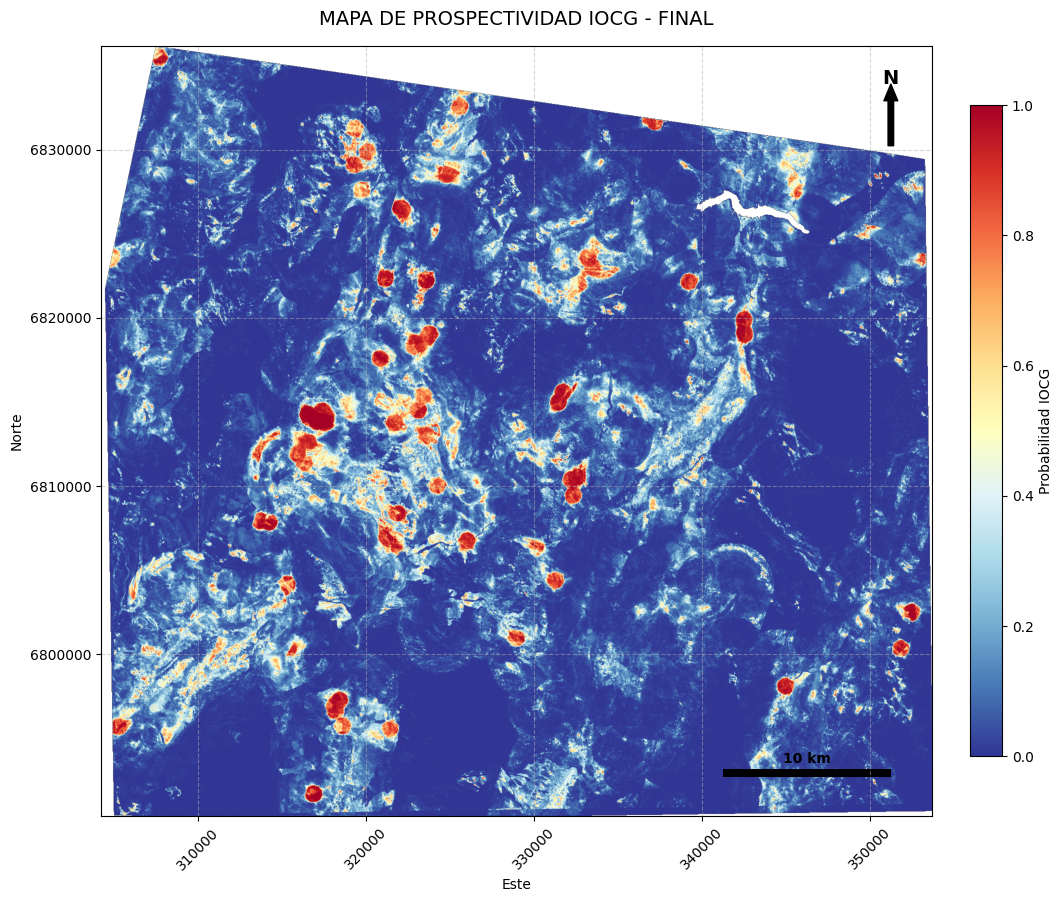

 PNG guardado en: /content/drive/MyDrive/Proyectoprospectivo/Data/raster/Mapa_Prospectividad_PRESENTACION.png


In [25]:
# 7. RECORTE E IMPORTACION TIF Y PNG

# 1. CONFIGURACIÓN Y RUTAS
tif_temp_path = '/content/drive/MyDrive/Proyectoprospectivo/Data/raster/Mapa_Prospectividad_TEMP.tif'
shp_path      = '/content/drive/MyDrive/Proyectoprospectivo/Data/GEOL/shapes_reproyectados/GB_LITO_P_32719.shp'
out_tif       = '/content/drive/MyDrive/Proyectoprospectivo/Data/raster/Mapa_Prospectividad_OFICIAL.tif'
out_png       = '/content/drive/MyDrive/Proyectoprospectivo/Data/raster/Mapa_Prospectividad_PRESENTACION.png'

# Parámetros Clave
PIXEL_SIZE = 30.0
CRS_PROJ   = 'EPSG:32719'
NODATA     = -9999.0

print("INICIANDO PROCESO FINAL (CORREGIDO)...")

# 2. GENERACIÓN DE RASTER BASE (INTERPOLACIÓN) ---
print("Interpolando datos (Linear)...")

# Definir límites y grilla
min_x, max_x = df_clean['Este_UTM'].min(), df_clean['Este_UTM'].max()
min_y, max_y = df_clean['Norte_UTM'].min(), df_clean['Norte_UTM'].max()
w = int((max_x - min_x) / PIXEL_SIZE)
h = int((max_y - min_y) / PIXEL_SIZE)

grid_x, grid_y = np.meshgrid(np.linspace(min_x, max_x, w), np.linspace(max_y, min_y, h))

# Interpolación
raster_data = griddata((df_clean['Este_UTM'], df_clean['Norte_UTM']),
                       df_clean['Probabilidad_IOCG'], (grid_x, grid_y), method='linear')
raster_data = np.nan_to_num(raster_data, nan=NODATA)

# Guardar Temporal
transform = from_origin(min_x, max_y, PIXEL_SIZE, PIXEL_SIZE)
with rasterio.open(tif_temp_path, 'w', driver='GTiff', height=h, width=w, count=1,
                   dtype=raster_data.dtype, crs=CRS_PROJ, transform=transform, nodata=NODATA) as dst:
    dst.write(raster_data, 1)

# 3. RECORTE CON SHAPEFILE (PARA ELIMINAR BORDE SOBREPUESTOS)
print("Recortando con Geología...")

# Carga y proyección
gdf = gpd.read_file(shp_path).to_crs(CRS_PROJ)

# Agregamos 'if g is not None' para saltar las filas vacías que pueden causar error
shapes = [g.__geo_interface__ for g in gdf.geometry if g is not None and g.type in ['Polygon', 'MultiPolygon']]

# Aplicar Máscara
with rasterio.open(tif_temp_path) as src:
    out_img, out_trans = mask(src, shapes, crop=True, nodata=NODATA)
    out_meta = src.meta.copy()

# Guardar Oficial
out_meta.update({"height": out_img.shape[1], "width": out_img.shape[2],
                 "transform": out_trans, "nodata": NODATA})
with rasterio.open(out_tif, "w", **out_meta) as dest:
    dest.write(out_img)

# 4. VISUALIZACIÓN
print("Generando PNG...")

with rasterio.open(out_tif) as src:
    data = src.read(1)
    # Máscara visual
    data_masked = np.ma.masked_where((data == NODATA) | (np.isnan(data)), data)
    left, bottom, right, top = src.bounds

    fig, ax = plt.subplots(figsize=(12, 10))
    im = ax.imshow(data_masked, cmap='RdYlBu_r', extent=[left, right, bottom, top])

    # Decoración
    plt.colorbar(im, ax=ax, fraction=0.035, pad=0.04).set_label('Probabilidad IOCG', fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.5); ax.set_xlabel('Este'); ax.set_ylabel('Norte')
    ax.ticklabel_format(style='plain', useOffset=False); plt.xticks(rotation=45)

    # Norte
    ax.text(0.95, 0.95, 'N', transform=ax.transAxes, ha='center', fontsize=14, fontweight='bold')
    ax.annotate('', xy=(0.95, 0.95), xytext=(0.95, 0.87), xycoords='axes fraction',
                arrowprops=dict(facecolor='black', width=4, headwidth=10))

    # Escala
    width_m = right - left
    bar_len = max(1000, round((width_m * 0.2) / 1000) * 1000)
    sx, sy = right - (width_m * 0.05) - bar_len, bottom + ((top - bottom) * 0.05)

    ax.add_patch(mpatches.Rectangle((sx, sy), bar_len, (top-bottom)*0.01, fc='black'))
    ax.text(sx + bar_len/2, sy + (top-bottom)*0.015, f'{int(bar_len/1000)} km',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

    plt.title("MAPA DE PROSPECTIVIDAD IOCG - FINAL", fontsize=14, pad=15)
    plt.savefig(out_png, dpi=300, bbox_inches='tight')
    plt.show()

print(f" PNG guardado en: {out_png}")